In [ ]:
'''
MAIN IMPLEMENTATION DETAILS:
Implementing the Transfer Learning Tutorial as taurght by Sasank Chilamkurthy
for computer vision as found @ https://pytorch.org/
tutorials/beginner/transfer_learning_tutorial.html 

AND SOME IMPLEMENTATION DETAILS:
from the TorchVision Instance Segmentation Finetuning Turorial as found @ 
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/
torchvision_finetuning_instance_segmentation.ipynb#scrollTo=cFHKCvCTxiff
and from https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
in regards to transformations
'''

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import os
import numpy as np
from torchvision import models
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import torch
import torch.utils.data
import torchvision.transforms as T
from torchinfo import summary
import copy
from PIL import Image
import matplotlib.pyplot as plt
import time

In [9]:
img_dir = "/mnt/chromeos/GoogleDrive/MyDrive/Datasets/models/images/"
target = "/mnt/chromeos/GoogleDrive/MyDrive/Datasets/models/labels.txt"

In [57]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Resize([255, 255]),
    T.Normalize(
         mean=[0.485, 0.456, 0.406], 
         std= [0.229, 0.224, 0.225]
     )
])


class CelebDataset(torch.utils.data.Dataset):
    def __init__(self, root, target):
        self.root = root
        self.imgs = list(sorted(os.listdir(root)))
        
        my_file = open(target, "r")
        data = my_file.read()
        data_into_list = data.split("\n")
        x=list(map(int,data_into_list[:-1]))
        self.target = list(sorted(x))
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        target = self.target[idx]
        img = Image.open(img_path).convert("RGB")
        pre = preprocess(img)
        torch_tar = torch.tensor(target)
        return pre, torch_tar
    
    def __len__(self):
        return len(self.imgs)      

In [73]:
image_datasets = CelebDataset(img_dir, target)
load = torch.utils.data.DataLoader(image_datasets, batch_size=2, shuffle=True)

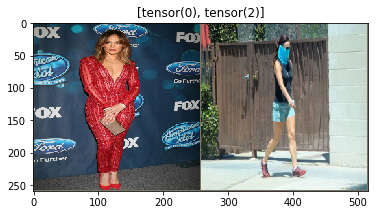

In [92]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(load))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

In [116]:
def train_model(model, criterion, optimizer, scheduler, phase, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
#         model.train()
        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in load:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 print(f'Prediction: {preds}')
#                 print(f'Actual: {labels.data}')
#                 print('-' * 10)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / 22
            epoch_acc = running_corrects.double() / 22

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [117]:
# loading pretrained resnet-18 model from 
# https://arxiv.org/pdf/1512.03385.pdf
# and using it as a fixed feature extractor
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

In [118]:
summary(model_ft)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11   

In [119]:
# Beginning size of each output sample is 1000
print(model_ft.fc.out_features)

# Finetuning the convnet by replacing last layer with custom layer for train
num_ftrs = model_ft.fc.in_features

# Setting size of each output sample is set to 3
model_ft.fc = nn.Linear(num_ftrs, 3)
print(model_ft.fc.out_features)

1000
3


In [120]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [121]:
phase = 'train'
image_classifier = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, phase)

Epoch 0/24
----------
train Loss: 1.3746 Acc: 0.2273

Epoch 1/24
----------
train Loss: 1.2742 Acc: 0.3636

Epoch 2/24
----------
train Loss: 1.7084 Acc: 0.3182

Epoch 3/24
----------
train Loss: 1.6367 Acc: 0.3636

Epoch 4/24
----------
train Loss: 1.3884 Acc: 0.5000

Epoch 5/24
----------
train Loss: 1.2292 Acc: 0.3636

Epoch 6/24
----------
train Loss: 0.8683 Acc: 0.5909

Epoch 7/24
----------
train Loss: 0.5547 Acc: 0.8182

Epoch 8/24
----------
train Loss: 0.6267 Acc: 0.8182

Epoch 9/24
----------
train Loss: 0.5784 Acc: 0.8182

Epoch 10/24
----------
train Loss: 0.6424 Acc: 0.7273

Epoch 11/24
----------
train Loss: 0.7024 Acc: 0.6364

Epoch 12/24
----------
train Loss: 0.6268 Acc: 0.7273

Epoch 13/24
----------
train Loss: 0.7030 Acc: 0.6364

Epoch 14/24
----------
train Loss: 0.4787 Acc: 0.8182

Epoch 15/24
----------
train Loss: 0.6038 Acc: 0.8182

Epoch 16/24
----------
train Loss: 0.6648 Acc: 0.6818

Epoch 17/24
----------
train Loss: 0.5386 Acc: 0.8636

Epoch 18/24
--------

In [ ]:
# my_file = open(target, "r")
# data = my_file.read()
# data_into_list = data.split("\n")
# x=list(map(int,data_into_list[:-1]))
# target = list(sorted(x))

In [ ]:
# imgs = list(sorted(os.listdir(img_dir)))
# img_path = os.path.join(img_dir, imgs[3])
# img = Image.open(img_path).convert("RGB")
# x=preprocess(img)
# y=x.permute(1,2,0)
# p=y.numpy()
# plt.imshow(p)

In [115]:
for phase in ['train']:
    print(phase)

train
